<a href="https://colab.research.google.com/github/1nature/1nature/blob/main/EDAofMovies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ydata-profiling
import pandas as pd
from ydata_profiling import ProfileReport

In [ ]:
# Load data
df = pd.read_csv("/content/sample_data/kaggle_movies.csv")


In [ ]:
# Dataset overview
df.head(5)
#df.shape
#df.dtypes

In [ ]:
# Check duplicates
# df[df.duplicated()]
# How to remove duplicates?

In [ ]:
# Check missing values per feature
# df.isna().sum()

In [ ]:
# Get info
# df.info()

In [ ]:
# Describe data
#df.describe()
df.describe(include='object')

In [ ]:
# Missing cells per feature
#
# round(df.isna().sum().sum() / df.size * 100, 1) # % of missing cells
df.head(5)

In [ ]:
# More features
col_cats = ["MOVIES", "YEAR", "GENRE", "RATING", "ONE-LINE", "STARS", "VOTES", "RunTime", "Gross"]

# for col in col_cats:
#   categories = df.groupby(col).size()
#   print(categories)

In [ ]:
# Profiling using ydata-profiling:
# Generate report
# profile = ProfileReport(df, title="Movies Data Profile")
# Save the report to .html
# profile.to_file("movies_data_report.html")

In [ ]:
# Remove odd characters
df[["GENRE", "ONE-LINE", "STARS"]] = df[["GENRE", "ONE-LINE", "STARS"]].replace("[^a-zA-Z0-9]", "")
df["GENRE"] = df["GENRE"].str.replace("\n", "").str.strip()
df["ONE-LINE"] = df["ONE-LINE"].str.replace("\n", "").str.strip()
df["STARS"] = df["STARS"].str.replace("\n", "").str.strip()


In [ ]:
df.head()

In [ ]:
# Check the "STARS"
df["STARS"].head(5)

In [ ]:
# Retain only the stars. Get rid of the director

def extract_director(stars):
  for piece in stars.split("|"): # split on ‘|’, look for the piece that starts with ‘Director:’
    piece = piece.strip()
    # Check if 'Director:' is in the piece before attempting to split and access index 1
    if piece.startswith("Director:"):
      return piece.split("Director:")[1].strip() # return what comes after the colon
  return "Unknown"

def extract_stars(stars):
  if "Stars:" in stars: # Also make this check more robust
    return stars.split("Stars:")[1].strip()
  return "Unknown"



df["DIRECTOR"] = df["STARS"].apply(extract_director)
df["STARS"]    = df["STARS"].apply(extract_stars)

# df.head(5)

In [ ]:
# Check head again
df.head(5)

In [ ]:
# Check info again
df.info()

In [ ]:
# Year formatting
# sequence of exactly four digits in each string of the Series and extract it
df["YEAR"]=df["YEAR"].astype(str)
df["YEAR"]=df["YEAR"].str.extract(r"(\d{4})")
df["YEAR"].isnull().sum()

In [ ]:
# Sort the year
# Sorts the DataFrame  by the values in the  column (ascending by default).
# - Resets the index after sorting so that it runs from 0 to n-1
# drop=True means the old index is discarded (not added as a new column).
df = df.sort_values(by="YEAR").reset_index(drop=True)
df

In [ ]:
# Interpolate nulls in the year column
df["YEAR"] = df["YEAR"].astype("Int64")
df["YEAR"] = df["YEAR"].interpolate()
df["YEAR"].isnull().sum() # Check for null values

In [ ]:
# Count duplicates
print(df.duplicated().sum())

In [ ]:
# Drop duplicates and check for them again
df.drop_duplicates(inplace=True)
print(df.duplicated().sum())

In [ ]:
df.head()

In [ ]:
# Clean votes column
# Remove commas from votes
df["VOTES"] = df["VOTES"].astype(str).str.replace(",", "")
# Convert votes to int
df["VOTES"] = pd.to_numeric(df["VOTES"], errors="coerce")
# Check for null in votes column
df["VOTES"].isnull().sum()
# fill null cells
df["VOTES"] = df["VOTES"].fillna(0)

In [ ]:
import numpy as np
# Convert gross revenue strings

def parse_gross(value):
    if pd.isna(value):
        return np.nan

    value = str(value).strip()
    multiplier = 1

    if "M" in value:
        multiplier = 1e6
    elif "K" in value:
        multiplier = 1e3
    elif "B" in value:
        multiplier = 1e9

    try:
        number = float(value[:-1])  # remove suffix
        return number * multiplier
    except ValueError:
        return np.nan

df["Gross"] = df["Gross"].apply(parse_gross)
df

In [ ]:
# fill in missing or zero values in the  and  columns using median values
# But only when the other column has a valid (non-zero) value
median_gross = df[df["Gross"] > 0]["Gross"].median() # Compute median of "Gross", exclude 0s
median_votes = df[df["VOTES"] > 0]["VOTES"].median() # Compute median of "Votes", exclude 0s

# Fill in missing Gross where Vote > 0 is valid
df.loc[(df["Gross"] == 0) & (df["VOTES"] > 0), "Gross"] = median_gross
# Replace Votes if it's 0 but gross > 0
df.loc[(df['VOTES'] == 0) & (df['Gross'] > 0), 'VOTES'] = median_votes

#  If both are 0, leave as is (no action needed)

In [ ]:
# Check for 0 values in Gross and Votes
df[(df["Gross"] == 0) & (df["VOTES"] > 0)] # Both should be empty
df[(df['VOTES'] == 0) & (df['Gross'] > 0)]

In [ ]:
# Fill Gross with 0s
df["Gross"] = df["Gross"].fillna(0)

In [ ]:
# Genre
# df["GENRE"]
# Check null values in GENRE
df["GENRE"].isnull().sum()

In [ ]:
# Remove spaces around commas in Genre
df["GENRE"] = df["GENRE"].astype(str)\
.str.replace("\n", "", regex=True)\
.str.strip().str.replace(r"\s*,\s*", ', ', regex=True)

In [ ]:
# Count Directors
df["DIRECTOR"].value_counts()

In [ ]:
# Calculate the most common genre for each Director
mode_genre = df.groupby('DIRECTOR')['GENRE'] \
               .agg(lambda x: x.mode().iloc[0]
                             if not x.mode().empty
                             else 'Unknown')

# fill the missing GENRE entries using DIRECTOR's mode
df['GENRE'] = df['GENRE'].fillna(df['DIRECTOR'].map(mode_genre))

In [ ]:
# Fill the rest with unknown
df['GENRE'] = df['GENRE'].fillna('Unknown')
df['GENRE'].isna().sum()

In [ ]:
# ONE-LINE
# Replace "Add a Plot" with unknown
df["ONE-LINE"] = df["ONE-LINE"].replace("Add a Plot","Unknown")

In [ ]:
# Rating column
# Fill NaN based on group median (Director + GENRE)
df['RATING'] = df.groupby(['DIRECTOR', 'GENRE'])['RATING'].\
transform(lambda x: x.fillna(x.median(skipna=True)))

# Then fill any remaining NaNs with overall median
overall_median = df['RATING'].median(skipna=True)
df['RATING'] = df['RATING'].fillna(overall_median)

print(df['RATING'].isna().sum())

In [ ]:
# Check missing DF values
df.isna().sum()

In [ ]:
# Runtime
df['RunTime'] = df.groupby(df['GENRE'].replace(',','',regex=True).str.strip())['RunTime'].transform(lambda x: x.fillna(x.median()))
# remaining values
df['RunTime']=df['RunTime'].fillna(df['RunTime'].median())
df['RunTime']

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Boxplot Runtime
plt.figure(figsize=(10, 6))
plt.boxplot(df['RunTime'])
plt.title('Boxplot of Runtime')
plt.xlabel('Runtime Minutes')
plt.grid(True)
plt.show()

In [ ]:
# First & Third Quartiles of the Runtime
# Calculate the interquartile range IQR
Q1 = df['RunTime'].quantile(0.25)
Q3 = df['RunTime'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df = df[(df['RunTime'] >= lower) & (df['RunTime'] <= upper)]

In [ ]:
# Boxplot of Runtime after applying IQR
plt.figure(figsize=(6, 4))
plt.boxplot(df['RunTime'])
plt.title('Boxplot of RunTime')
plt.xlabel('RunTime (minutes)')
plt.grid(True)
plt.show()

In [ ]:
# Save data after IQR
df.to_csv("movies_data_cleaned.csv", index=False)

In [ ]:
# View cleaned data
df_clean = pd.read_csv("/content/movies_data_cleaned.csv")
df_clean.head()

In [ ]:
# Top 10 rated movies
top_10 = df.sort_values(by="RATING", ascending=False).head(10)
top_10[["MOVIES", "YEAR", "RATING"]]

In [ ]:
import seaborn as sns
# Bar plot of the top ten rated movies
plt.figure(figsize=(10,6))
sns.barplot(data=top_10, y='MOVIES', x='RATING', hue= "MOVIES",
            palette='viridis', legend = False)
plt.title("Top 10 Highest-Rated Movies")
plt.xlabel("Rating")
plt.ylabel("Movie")
plt.show()

In [ ]:
# Distribution of movie ratings
sns.histplot(data=df["RATING"], bins=20, kde=True)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

In [ ]:
from collections import Counter
# Most common movie Genres
all_genres = df_clean["GENRE"].str.split(", ")
genres = []
for sublist in all_genres:
  if isinstance(sublist, list):
    for genre in sublist:
      genres.append(genre)
genre_count = Counter(genres)
# genre_count
genre_count.most_common(10)

In [ ]:
# Visualise Genres
plt.figure(figsize=(10,6))
df_vis = pd.DataFrame(genre_count.items(), columns=['Genre', 'Count'])
sns.barplot(data=df_vis.head(10),y='Genre',x='Count', hue= "Genre",
            palette='viridis', legend=False)
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.title("Most common Genres")
plt.show()

In [ ]:
# Not clear from this point!
# Visualise Genre vs Runtime
df_explode = df_clean.dropna(subset=['GENRE']).copy()
df_explode['GENRE'] = df_explode['GENRE'].str.split(', ')
df_explode = df_explode.explode('GENRE')

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_explode, x='GENRE', y='RunTime')
plt.xticks(rotation=90)
plt.title("Runtime per Genre")
plt.show()

In [ ]:
# Relations between Votes & Gross
sns.regplot(data=df_clean, x="VOTES", y="Gross",x_jitter=0.1)
plt.title("Votes vs Gross")
plt.show()

In [ ]:
# Which directors have the most movies?
df_explode2 = df_clean.dropna(subset=['DIRECTOR']).copy()
df_explode2['DIRECTOR'] = df_explode2['DIRECTOR'].str.split(', ')
df_explode2 = df_explode2.explode('DIRECTOR')

top_directors = (
    df_explode2[df_explode2['DIRECTOR'] != "Unknown"]['DIRECTOR']
    .value_counts()
    .head(10)
    .reset_index()
)
top_directors.columns = ['DIRECTOR', 'Movie Count']

plt.figure(figsize=(12, 6))
sns.barplot(data=top_directors, x='DIRECTOR', y='Movie Count',
            hue='DIRECTOR', palette='viridis', legend=False)
plt.title("Top 10 Directors by Number of Movies")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# trends in movie production across years
df_clean['YEAR'].value_counts().sort_index().plot(kind="line", marker='x',
                                                  color='teal')

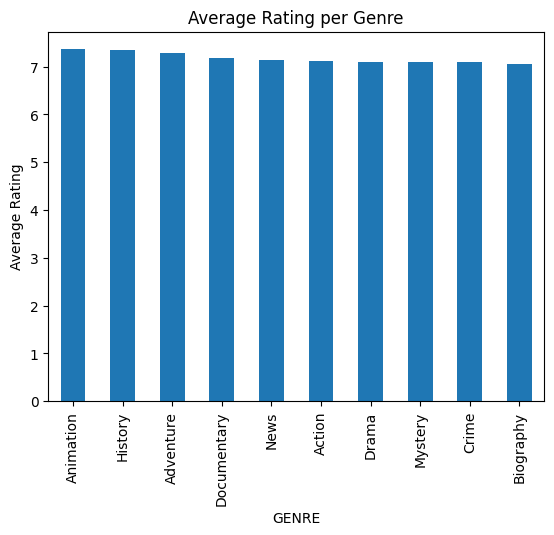

In [107]:
# Average rating per genre
genre_rating = df_explode.groupby('GENRE')['RATING'].mean().\
sort_values(ascending=False).head(10)
genre_rating.plot(kind='bar', title='Average Rating per Genre')
plt.ylabel("Average Rating")
plt.show()

In [ ]:
# Stars that appear most frequently
df_explode2 = df_clean.dropna(subset=['STARS']).copy()
df_explode2["STARS"] = df_explode2["STARS"].str.split(", ")
df_explode2 = df_explode2.explode("STARS")
topstars = (
    df_explode2[df_explode2['STARS'] != "Unknown"]['STARS']
    .value_counts()
    .head(10)
    .reset_index()
)
topstars.columns = ['STARS', 'Movie Count']
df_explode2.head()

In [ ]:
# Plot the above
plt.figure(figsize=(12, 6))
sns.barplot(data=topstars, x='STARS', y='Movie Count')
plt.title("Top 10 STARS by Number of Movies")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Relations between Runtime & Rating
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_clean,x='RunTime',y='RATING')
plt.title("RunTime Vs Rating")
plt.show()